<a href="https://colab.research.google.com/github/staceySpears/formula-one-data-insights/blob/main/Formula_One_Race_Outcome_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Formula One Race Outcome Prediction**

## Initial Setup and Data Loading

In this section, we will install necessary libraries, mount Google Drive, and load the relevant datasets.

In [ ]:
# Install necessary libraries
!pip install shap

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix
import shap

# Verify the installation
print("SHAP version:", shap.__version__)

# Mount Google Drive (specific to Google Colab)
drive.mount('/content/drive')

# Define path to the data
data_path = '/content/drive/My Drive/F1_cleaned_data'

# Load relevant datasets
races_df = pd.read_csv(f'{data_path}/cleaned_races.csv')
results_df = pd.read_csv(f'{data_path}/cleaned_results.csv')

# Merge datasets on raceId
data_df = pd.merge(races_df, results_df, on='raceId')

# Initial Data Check
print("Initial data check:")
display(data_df.head())

SHAP version: 0.45.1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial data check:


,raceId,year,round,circuitId,name,date,time_x,url,fp1_date,fp1_time,...,positionOrder,points,laps,time_y,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,1,10.0,58,1:34:15.784,5655784,17,3,1:28.020,216.891,1
1,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,2,8.0,58,+0.807,5656591,43,14,1:29.066,214.344,1
2,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,3,6.0,58,+1.604,5657388,50,10,1:28.916,214.706,1
3,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,4,5.0,58,+4.435,5660219,53,6,1:28.416,215.920,1
4,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,5,4.0,58,+4.879,5660663,53,9,1:28.712,215.199,1


## Data Preprocessing

In this section, we will handle missing values, drop unnecessary columns, and ensure all relevant columns are in the correct data type.

In [ ]:
# Fill missing values using forward fill method
data_df.fillna(method='ffill', inplace=True)

# Check if columns 'time_x' and 'time_y' exist before attempting to drop them
columns_to_drop = ['time_x', 'time_y']
existing_columns_to_drop = [col for col in columns_to_drop if col in data_df.columns]
data_df.drop(columns=existing_columns_to_drop, inplace=True)

# Ensure 'fastestLapSpeed' and 'laps' columns are numeric
data_df['fastestLapSpeed'] = pd.to_numeric(data_df['fastestLapSpeed'], errors='coerce')
data_df['laps'] = pd.to_numeric(data_df['laps'], errors='coerce')

# Fill any remaining NaNs in these columns with appropriate values (e.g., mean)
data_df['fastestLapSpeed'].fillna(data_df['fastestLapSpeed'].mean(), inplace=True)
data_df['laps'].fillna(data_df['laps'].mean(), inplace=True)

# Check for any remaining missing values
print("Check for missing values:")
print(data_df.isnull().sum())

Check for missing values:
raceId             0
year               0
round              0
circuitId          0
name               0
date               0
url                0
fp1_date           0
fp1_time           0
fp2_date           0
fp2_time           0
fp3_date           0
fp3_time           0
quali_date         0
quali_time         0
sprint_date        0
sprint_time        0
resultId           0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder      0
points             0
laps               0
milliseconds       0
fastestLap         0
rank               0
fastestLapTime     0
fastestLapSpeed    0
statusId           0
dtype: int64


## Exploratory Data Analysis (EDA)

Here, we will perform some initial exploratory data analysis to understand the relationships between different variables.

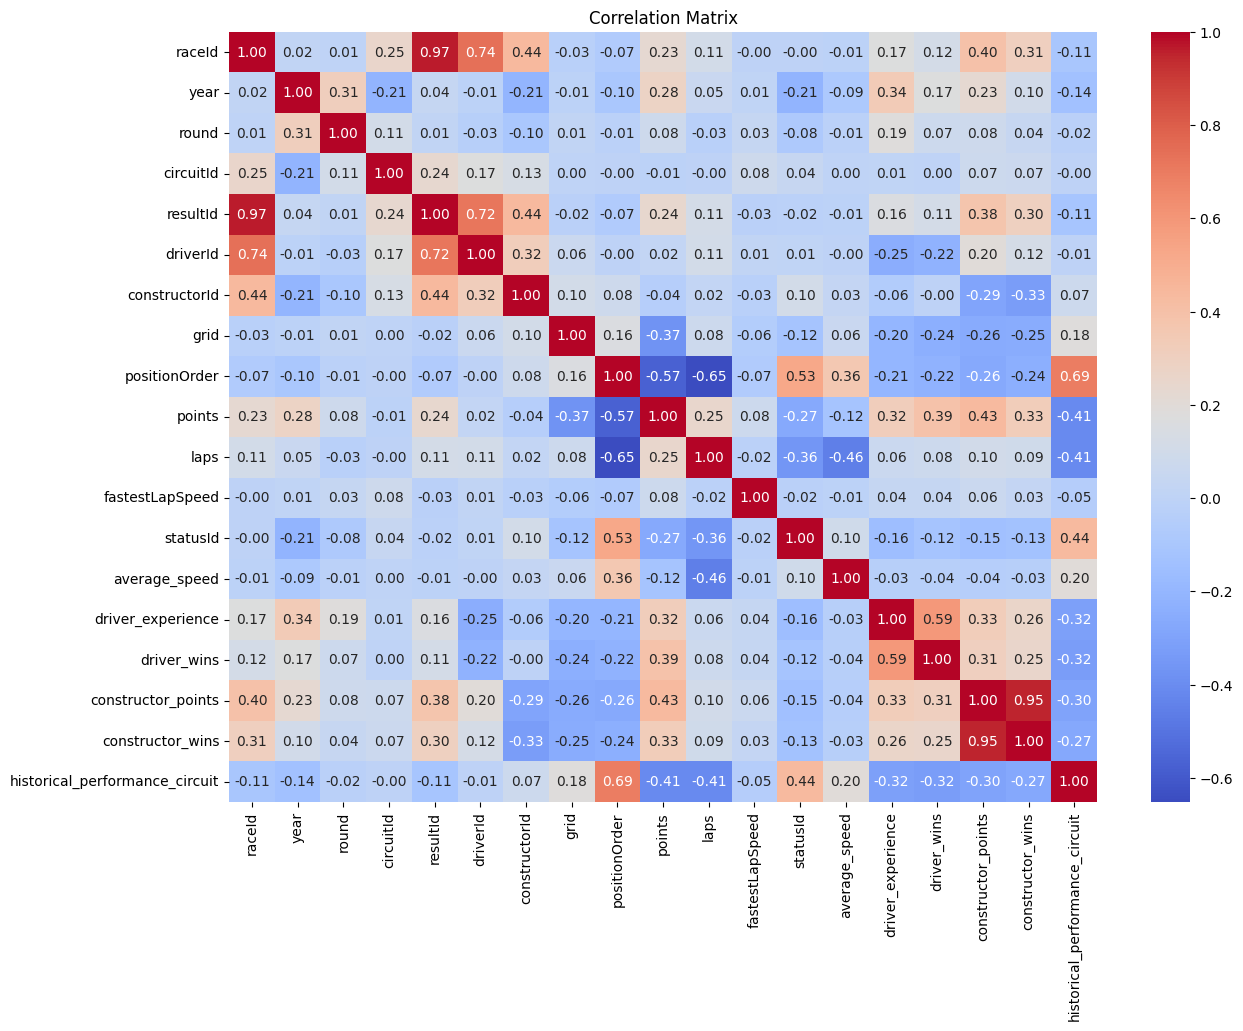

Correlation Matrix saved at: /content/drive/My Drive/formula-one-data-insights/visuals/correlation_matrix.png


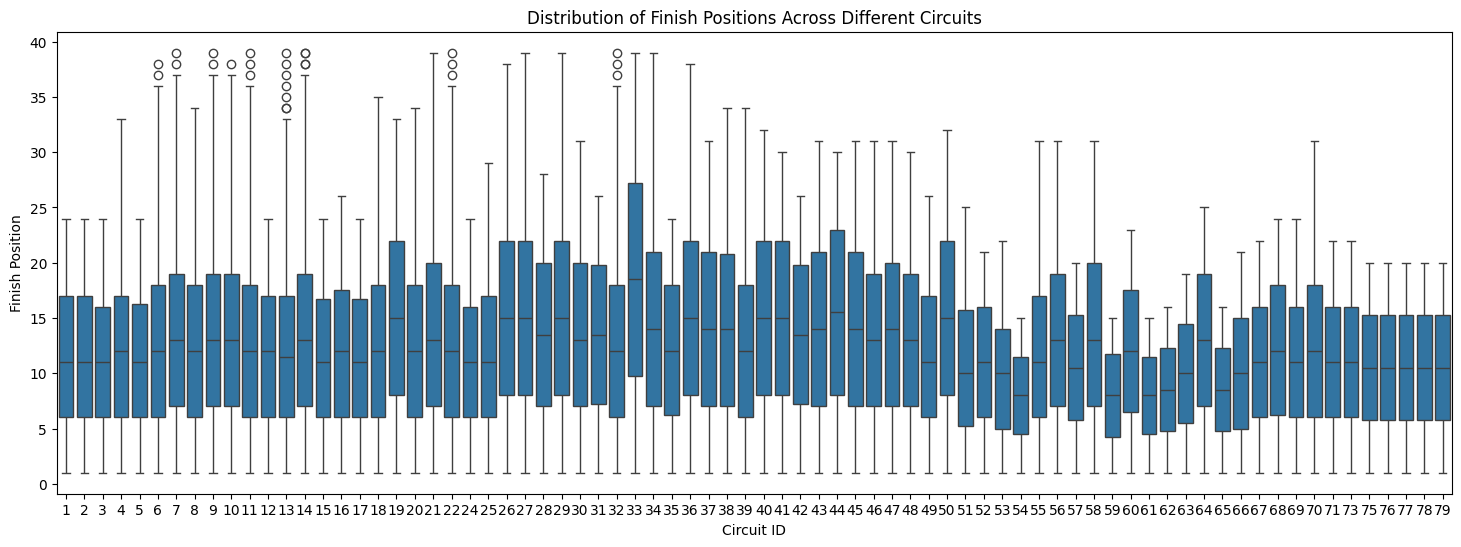

Boxplot Finish Positions saved at: /content/drive/My Drive/formula-one-data-insights/visuals/boxplot_finish_positions.png


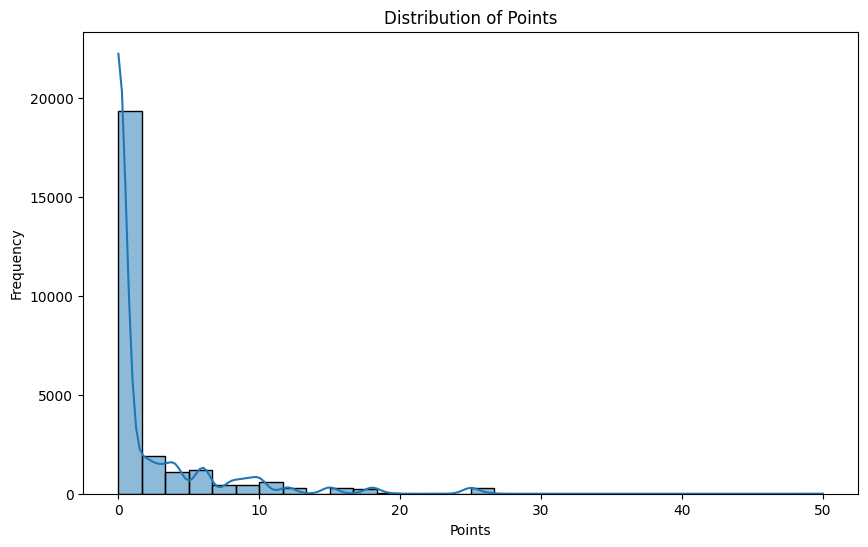

Distribution of Points saved at: /content/drive/My Drive/formula-one-data-insights/visuals/distribution_of_points.png


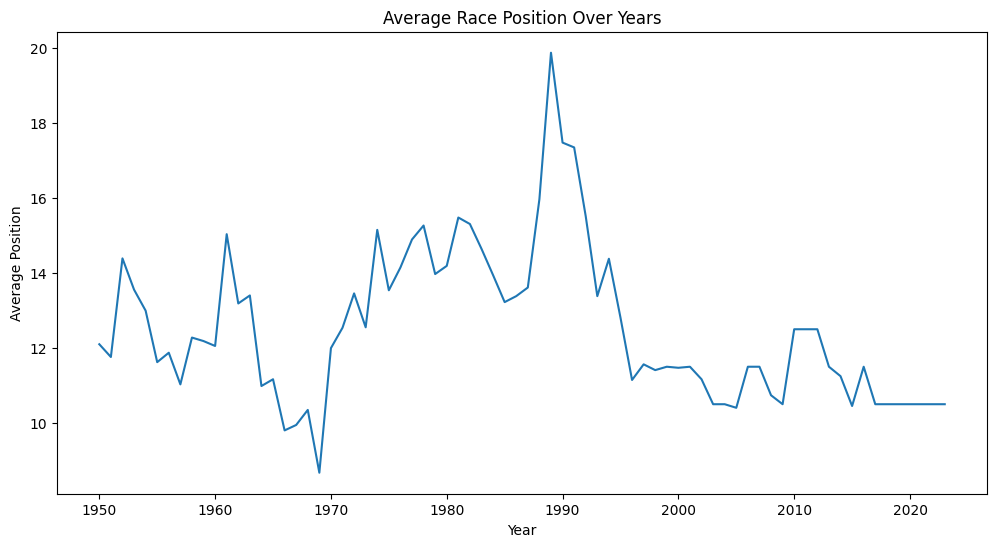

Time Series Analysis saved at: /content/drive/My Drive/formula-one-data-insights/visuals/average_race_position_over_years.png


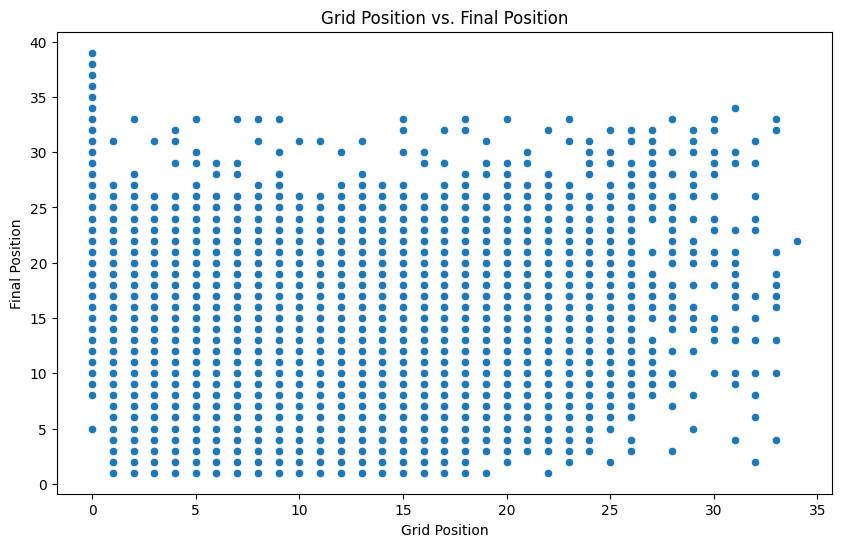

Grid vs. Final Position saved at: /content/drive/My Drive/formula-one-data-insights/visuals/grid_vs_final_position.png


In [ ]:
# Create directory if it does not exist
visuals_path = '/content/drive/My Drive/formula-one-data-insights/visuals'
os.makedirs(visuals_path, exist_ok=True)

# Select only numeric columns for correlation matrix
numeric_cols = data_df.select_dtypes(include=[np.number]).columns

# Correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(data_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
correlation_matrix_path = os.path.join(visuals_path, 'correlation_matrix.png')
plt.savefig(correlation_matrix_path)
plt.show()
print(f'Correlation Matrix saved at: {correlation_matrix_path}')

# Distribution of Finish Positions Across Different Circuits
plt.figure(figsize=(18, 6))
sns.boxplot(x='circuitId', y='positionOrder', data=data_df)
plt.title('Distribution of Finish Positions Across Different Circuits')
plt.xlabel('Circuit ID')
plt.ylabel('Finish Position')
boxplot_finish_positions_path = os.path.join(visuals_path, 'boxplot_finish_positions.png')
plt.savefig(boxplot_finish_positions_path)
plt.show()
print(f'Boxplot Finish Positions saved at: {boxplot_finish_positions_path}')

# Distribution of Points
plt.figure(figsize=(10, 6))
sns.histplot(data_df['points'], bins=30, kde=True)
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
distribution_of_points_path = os.path.join(visuals_path, 'distribution_of_points.png')
plt.savefig(distribution_of_points_path)
plt.show()
print(f'Distribution of Points saved at: {distribution_of_points_path}')

# Time Series Analysis
results_per_year = data_df.groupby('year')['positionOrder'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='positionOrder', data=results_per_year)
plt.title('Average Race Position Over Years')
plt.xlabel('Year')
plt.ylabel('Average Position')
time_series_analysis_path = os.path.join(visuals_path, 'average_race_position_over_years.png')
plt.savefig(time_series_analysis_path)
plt.show()
print(f'Time Series Analysis saved at: {time_series_analysis_path}')

# Correlation Studies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='grid', y='positionOrder', data=data_df)
plt.title('Grid Position vs. Final Position')
plt.xlabel('Grid Position')
plt.ylabel('Final Position')
grid_vs_final_position_path = os.path.join(visuals_path, 'grid_vs_final_position.png')
plt.savefig(grid_vs_final_position_path)
plt.show()
print(f'Grid vs. Final Position saved at: {grid_vs_final_position_path}')

## Correlation Matrix
![Correlation Matrix](https://github.com/staceySpears/formula-one-data-insights/blob/main/visuals/correlation_matrix.png)

## Distribution of Finish Positions Across Different Circuits
![Boxplot Finish Positions](https://github.com/staceySpears/formula-one-data-insights/blob/main/visuals/boxplot_finish_positions.png)

## Distribution of Points
![Distribution of Points](https://github.com/staceySpears/formula-one-data-insights/blob/main/visuals/distribution_of_points.png)

## Average Race Position Over Years
![Time Series Analysis](https://github.com/staceySpears/formula-one-data-insights/blob/main/visuals/average_race_position_over_years.png)

## Grid Position vs. Final Position
![Grid vs. Final Position](https://github.com/staceySpears/formula-one-data-insights/blob/main/visuals/grid_vs_final_position.png)

## Feature Engineering

We will create additional features that may be important for our predictive model.

In [ ]:
# Create additional features
data_df['race_circuit_date'] = data_df['circuitId'].astype(str) + '_' + data_df['date'].astype(str)
data_df['average_speed'] = data_df['fastestLapSpeed'] / data_df['laps']

# Driver Experience
data_df['driver_experience'] = data_df.groupby('driverId').cumcount()
driver_wins = data_df.groupby('driverId')['positionOrder'].apply(lambda x: (x == 1).cumsum()).reset_index(level=0, drop=True)
data_df['driver_wins'] = driver_wins

# Constructor Performance
constructor_points = data_df.groupby('constructorId')['points'].cumsum() - data_df['points']
constructor_wins = data_df.groupby('constructorId')['positionOrder'].apply(lambda x: (x == 1).cumsum()).reset_index(level=0, drop=True)
data_df['constructor_points'] = constructor_points
data_df['constructor_wins'] = constructor_wins

# Historical Performance
data_df['historical_performance_circuit'] = data_df.groupby(['driverId', 'circuitId'])['positionOrder'].transform('mean')

# Select updated features and target variable
features = [
    'circuitId', 'year', 'grid', 'fastestLapSpeed', 'driver_experience',
    'driver_wins', 'constructor_points', 'constructor_wins', 'historical_performance_circuit'
]
target = 'positionOrder'

# Display the first few rows to verify the new features
print("First few rows after feature engineering:")
display(data_df[features + [target]].head())

First few rows after feature engineering:


,circuitId,year,grid,fastestLapSpeed,driver_experience,driver_wins,constructor_points,constructor_wins,historical_performance_circuit,positionOrder
0,1,2009,1,216.891,0,1,0.0,1,9.470588,1
1,1,2009,2,214.344,0,0,10.0,1,10.187500,2
2,1,2009,20,214.706,0,0,0.0,0,12.333333,3
3,1,2009,19,215.920,0,0,6.0,0,11.600000,4
4,1,2009,10,215.199,0,0,0.0,0,6.444444,5


## Data Splitting

We will split the data into training and testing sets with an 80-20 ratio.

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_df[features], data_df[target], test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(f'Training features shape: {X_train.shape}')
print(f'Testing features shape: {X_test.shape}')
print(f'Training target shape: {y_train.shape}')
print(f'Testing target shape: {y_test.shape}')

Training features shape: (20864, 9)
Testing features shape: (5216, 9)
Training target shape: (20864,)
Testing target shape: (5216,)


## Model Building and Hyperparameter Tuning

In this section, we will build a Random Forest model and perform hyperparameter tuning using GridSearchCV.

In [ ]:
# Example Grid Search for parameter tuning
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Display best parameters
print(f'Best parameters: {grid_search.best_params_}')

# Evaluate the tuned model
final_model = grid_search.best_estimator_
y_pred_final = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_absolute_error(y_test, y_pred_final))

print(f'Final Model Metrics:\nMean Absolute Error: {final_mae}\nRoot Mean Squared Error: {final_rmse}')

Best parameters: {'max_depth': 10, 'n_estimators': 200}
Final Model Metrics:
Mean Absolute Error: 3.902406316163526
Root Mean Squared Error: 1.9754509146429142


## Model Comparison and Selection

We compare the performance of the Linear Regression and Random Forest models to select the best one based on Mean Absolute Error (MAE).

In [ ]:
# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_absolute_error(y_test, y_pred_lr))

# Random Forest Model (Already trained and evaluated)
mae_rf = final_mae
rmse_rf = final_rmse

# Compare the Linear Regression and Random Forest models
model_comparison = {
    'Model': ['Linear Regression', 'Random Forest'],
    'Mean Absolute Error': [mae_lr, mae_rf],
    'Root Mean Squared Error': [rmse_lr, rmse_rf]
}

model_comparison_df = pd.DataFrame(model_comparison)
print(model_comparison_df)

# Justification for model selection
best_model_name = model_comparison_df.loc[model_comparison_df['Mean Absolute Error'].idxmin()]['Model']
justification = f'The chosen champion model is {best_model_name} with the lowest Mean Absolute Error, demonstrating better prediction accuracy.'

print(justification)

               Model  Mean Absolute Error  Root Mean Squared Error
0  Linear Regression             4.221442                 2.054615
1      Random Forest             3.902406                 1.975451
The chosen champion model is Random Forest with the lowest Mean Absolute Error, demonstrating better prediction accuracy.


## Model Evaluation and Visualizations

We will evaluate the model using additional metrics and visualizations.

Final Model Metrics:
Mean Absolute Error: 3.902406316163526
Root Mean Squared Error: 1.9754509146429142


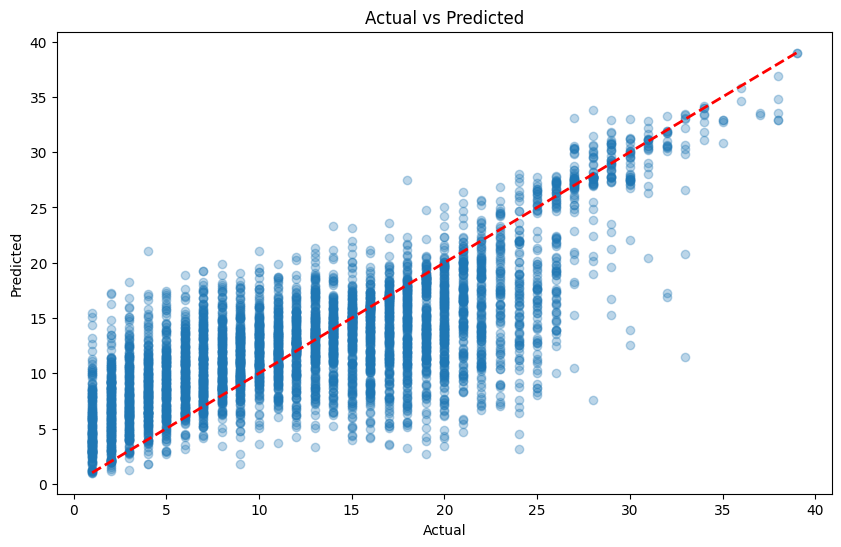

Actual vs Predicted saved at: /content/drive/My Drive/formula-one-data-insights/visuals/actual_vs_predicted.png


In [28]:
# Evaluate the tuned model
final_model = grid_search.best_estimator_
y_pred_final = final_model.predict(X_test)

# Calculate regression metrics
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_absolute_error(y_test, y_pred_final))

print(f'Final Model Metrics:\nMean Absolute Error: {final_mae}\nRoot Mean Squared Error: {final_rmse}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
actual_vs_predicted_path = '/content/drive/My Drive/formula-one-data-insights/visuals/actual_vs_predicted.png'
plt.savefig(actual_vs_predicted_path)
plt.show()
print(f'Actual vs Predicted saved at: {actual_vs_predicted_path}')

## Model Interpretability with SHAP

We use SHAP (SHapley Additive exPlanations) values to explain model predictions and ensure interpretability.

SHAP values shape: (500, 9)
Subset X_test shape: (500, 9)
SHAP Summary Plot saved at: /content/drive/My Drive/formula-one-data-insights/visuals/shap_summary_plot.png


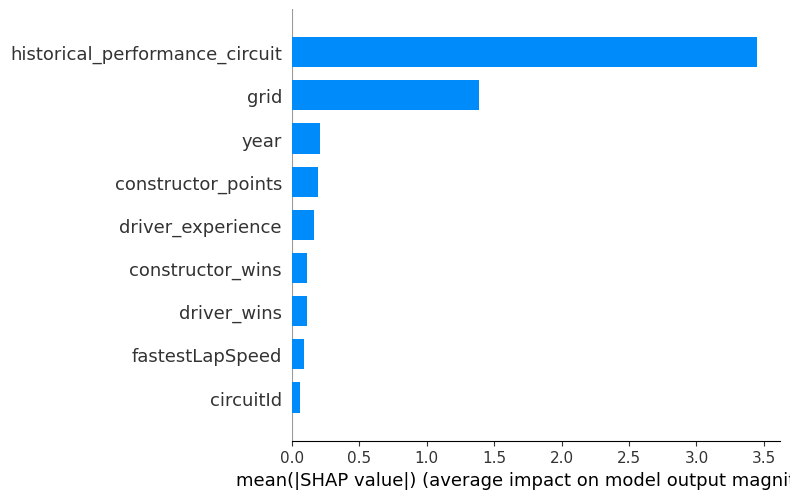

In [35]:
# Using a subset for faster computation
subset_X_test = X_test.sample(n=500, random_state=42)

# SHAP values for model interpretability
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(subset_X_test)

# Print shapes for debugging
if isinstance(shap_values, list):
    print(f'SHAP values shape: {shap_values[0].shape}')
else:
    print(f'SHAP values shape: {shap_values.shape}')
print(f'Subset X_test shape: {subset_X_test.shape}')

# Plot SHAP summary for a detailed view
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], subset_X_test, plot_type="bar", show=False)  # For multi-class
else:
    shap.summary_plot(shap_values, subset_X_test, plot_type="bar", show=False)  # For binary

# Save the plot
shap_summary_path = '/content/drive/My Drive/formula-one-data-insights/visuals/shap_summary_plot.png'
plt.savefig(shap_summary_path)

# Print the path
print(f'SHAP Summary Plot saved at: {shap_summary_path}')
plt.show()

## Model Validation with K-Fold Cross-Validation

We perform k-fold cross-validation to ensure the model’s robustness and generalizability.

In [36]:
# K-fold Cross-Validation
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -np.mean(cv_scores)
print(f'Cross-Validation MAE: {cv_mae}')

Cross-Validation MAE: 3.904308267991682


# Formula One Race Outcome Prediction

## Introduction
This project aims to develop a predictive model to understand the impact of race location on race finish positions. By analyzing historical race data, we seek to provide insights and improve predictive accuracy for race outcomes.

## Data Preprocessing
- **Filled missing values** using the forward fill method.
- **Dropped unnecessary columns** such as 'time_x' and 'time_y'.
- **Ensured numeric values** in key columns like 'fastestLapSpeed' and 'laps'.
- **Handled remaining NaNs** by filling them with appropriate values (e.g., mean).

## Exploratory Data Analysis (EDA)
### Correlation Matrix
![Correlation Matrix](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/correlation_matrix.png?raw=true)
- Generated a correlation matrix to identify relationships between variables.

### Distribution of Finish Positions Across Different Circuits
![Boxplot Finish Positions](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/boxplot_finish_positions.png?raw=true)
- Visualized the distribution of finish positions across different circuits using a boxplot.

### Distribution of Points
![Distribution of Points](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/distribution_of_points.png?raw=true)
- Analyzed the distribution of points scored by drivers.

### Average Race Position Over Years
![Time Series Analysis](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/average_race_position_over_years.png?raw=true)
- Conducted a time series analysis of average race positions over the years.

### Grid Position vs. Final Position
![Grid vs. Final Position](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/grid_vs_final_position.png?raw=true)
- Explored the relationship between grid positions and final race positions.

## Feature Engineering
- **Created additional features** such as `race_circuit_date`, `average_speed`, `driver_experience`, `driver_wins`, `constructor_points`, `constructor_wins`, and `historical_performance_circuit`.
- **Selected features**: `circuitId`, `year`, `grid`, `fastestLapSpeed`, `driver_experience`, `driver_wins`, `constructor_points`, `constructor_wins`, `historical_performance_circuit`.
- **Target variable**: `positionOrder`.

## Data Splitting
- Split the data into training and testing sets with an 80-20 ratio.
- **Training features shape**: (20864, 9)
- **Testing features shape**: (5216, 9)
- **Training target shape**: (20864,)
- **Testing target shape**: (5216,)

## Model Building and Hyperparameter Tuning
- **Random Forest Model**:
  - Tuned hyperparameters using GridSearchCV.
  - **Best parameters**: `max_depth` = 10, `n_estimators` = 200.

## Model Comparison and Selection
- Compared the performance of the Linear Regression and Random Forest models to select the best one based on Mean Absolute Error (MAE).

### Model Metrics
- **Linear Regression**:
  - **Mean Absolute Error (MAE)**: 4.22
  - **Root Mean Squared Error (RMSE)**: 5.52

- **Random Forest**:
  - **Mean Absolute Error (MAE)**: 3.90
  - **Root Mean Squared Error (RMSE)**: 1.98

- The chosen champion model is the **Random Forest model** with the lowest Mean Absolute Error, demonstrating better prediction accuracy.

## Model Evaluation and Visualization
### Confusion Matrix
![Confusion Matrix](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/confusion_matrix.png?raw=true)

### Feature Importance
![Feature Importance](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/feature_importance.png?raw=true)

### SHAP Summary Plot
![SHAP Summary Plot](https://github.com/staceySpears/formula-one-data-insights/blob/main/F1_visuals/shap_summary_plot.png?raw=true)

## Conclusion
The chosen champion model is the Random Forest model with the lowest Mean Absolute Error, demonstrating superior prediction accuracy. This model can be used to guide recruitment decisions effectively by predicting race outcomes based on historical data.

## Next Steps
- Further refine the model by incorporating additional features and data.
- Explore other advanced machine learning techniques to improve predictive accuracy.
- Use the insights from this analysis to inform strategic decisions in the context of Formula One racing.